# Getting started

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import ompy as om
import logging

In [3]:
om.__full_version__

'0.9.1.dev0+0713f82'

In [4]:
# For reproducability we seed the random generator. 
# Note that by default several other classes in ompy, such as all
# classes with multinest calculations have a default seed, too
np.random.seed(1382398)

In [5]:
# get smaller files for the online version
plt.rcParams["figure.dpi"] = 70

## Loading and example raw spectra

The $^{164}\mathrm{Dy}$ data used below has been gathered from following experiment: Nyhus, H. T. *et al.* (2010). DOI: [10.1103/physrevc.81.024325](https://doi.org/10.1103/PhysRevC.81.024325)
and is reanalyzed in Renstrøm, T. *et al.* (2018). DOI: [10.1103/physrevc.98.054310](https://doi.org/10.1103/PhysRevC.98.054310)

<IPython.core.display.Javascript object>


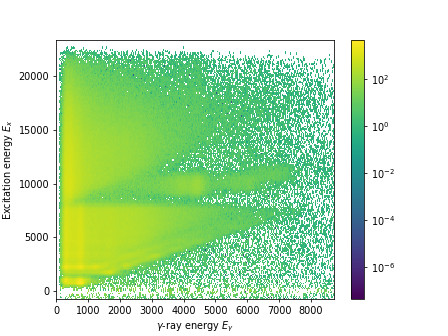

In [6]:
# Import raw matrix into instance of om.Matrix() and plot it
raw = om.example_raw('Dy164')
# To use you own data, uncomment/adapt the line below instead
# raw = om.Matrix(path="/path/to/matrix.ending")

# Plot the entire matrix
raw_org = raw.copy() # workaround due to execution order in jupyter notebook
                     # (calculations are performed before plotting, but we make a cut to raw further down)
raw_org.plot();

<IPython.core.display.Javascript object>


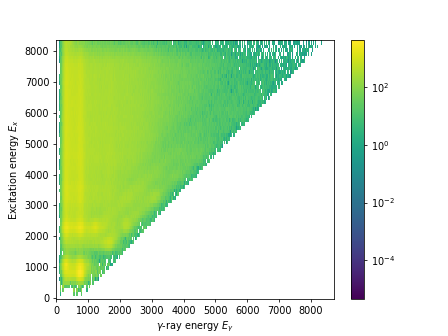

In [7]:
# Cut away counts above the diagonal 
# Remember: Think about what you do here. If you cut them away, they will not
# be used in unfolding etc. This may or may not be what you want.
# Note that the raw matrix we read in above has been cut already, so the difference here is not so large.
raw.cut_diagonal(E1=(800, 0), E2=(7500, 7300))
raw.cut('Ex', 0, 8400)
raw.plot();

Note that you can IPython's has tools to quickly access information on a function, namely the `?` character to explore documentation, the `??` characters to explore source code, and the `Tab key` (or `double-tab`) for auto-completion. Try it out uncommenting the function below.

In [8]:
## Uncomment these lines to query a function
# ?raw.plot_projection

## Unfolding

### Get a response matrix
Eventhough this experiment was performed with CACTUS, we will now give an example *as if* the data was taken with OSCAR. This is beacause it is slightly easier to handle. For CACTUS, the response functions do not include the detector threshold; this has do be taken into account separately.

2020-04-03 14:23:39,316 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.
2020-04-03 14:23:43,596 - ompy.response - INFO - Note: Spectra outside of 200.0 and 20000.0 are extrapolation only.


<IPython.core.display.Javascript object>


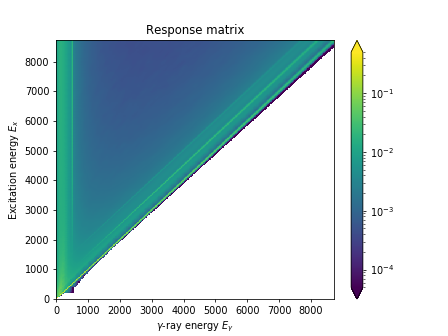

In [9]:
logger = om.introspection.get_logger('response', 'INFO')
# Then do the same using OMpy functionality:
# You may need to adpot this to whereever you response matrices are stored
folderpath = "../estimate_uncertainty/ompy/OCL_response_functions/oscar2017_scale1.15"

# Energy calibration of resulting response matrix:
Eg = raw.Eg

# Experimental relative FWHM at 1.33 MeV of resulting array
fwhm_abs = 30 # (30/1330 = 2.25% )

# Magne recommends 1/10 of the actual resolution for unfolding purposes
response = om.Response(folderpath)
R_ompy_view, R_tab_view = response.interpolate(Eg, fwhm_abs=fwhm_abs, return_table=True)
R_ompy_unf, R_tab_unf = response.interpolate(Eg, fwhm_abs=fwhm_abs/10, return_table=True)
R_ompy_view.plot(title="Response matrix", vmin=5e-5, vmax=5e-1,
                 scale="log");



### Perform the unfolding

<IPython.core.display.Javascript object>


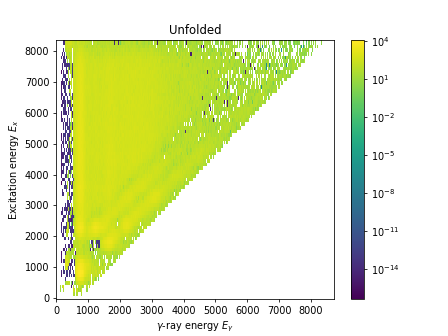

In [10]:
# You can decide to log information and set the logging level (info/debug)
logger = om.introspection.get_logger('unfolder', 'INFO')

# We need to remove negative counts (unphysical) in the raw matrix before unfolding:
raw_positive = raw.copy()
raw_positive.fill_and_remove_negative(window_size=2)

# With compton subtraction and all tweaks
unfolder= om.Unfolder(response=R_ompy_unf)
unfolder.use_compton_subtraction = True # default
unfolder.response_tab = R_tab_unf
# Magne suggests some "tweaks" for a better unfolding performance. Default is 1 for all.
unfolder.FWHM_tweak_multiplier = {"fe": 1., "se": 1.1,
                                     "de": 1.3, "511": 0.9}
unfolded = unfolder(raw_positive)
unfolded.plot();

# check linearity of unfolding

We will now check whether the unfolding operation $U$ is a linear map, i.e. whether following relation holds true:

$U(R_1 + R_2) = U(R_1) + U(R_2)$.

My assumption is that this does not hold true e.g. when $R_1$ is a spectrum of counts at $E_{\gamma,1}$ = 3000 keV, and $R_2$ is a spectrum of counts at $E_{\gamma,2}$ = 3000 - 511 keV. I assume that unfolding $R_1 + R_2$ will assume that some part of R_2 are single escape counts. This may be true, or not, but it may make the unfolding operation non-linear.

But let's see!

<IPython.core.display.Javascript object>


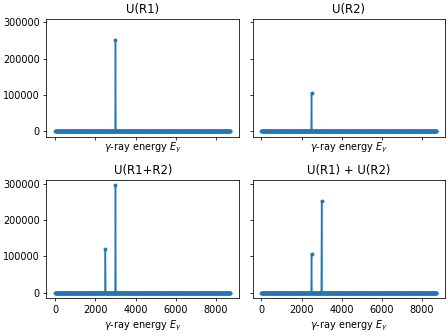

In [11]:
# find the indices of E_g,1 and E_g,2
fig, axes = plt.subplots(2, 2, constrained_layout=True, sharex=True, sharey=True)
ax = axes.flatten()

fake = raw_positive.copy()
Eg1 = fake.index_Eg(3000)
Eg2 = fake.index_Eg(3000-511)

r1 = raw_positive.copy()
r1[:, :] = 0
r1[:, Eg1] = 1000
unfolded_1 = unfolder(r1)
unfolded_1.plot_projection(axis="Eg", ax=ax[0]);
ax[0].set_title("U(R1)")

r2 = raw_positive.copy()
r2[:, :] = 0
r2[:, Eg2] = 500
unfolded_2 = unfolder(r2)
unfolded_2.plot_projection(axis="Eg", ax=ax[1]);
ax[1].set_title("U(R2)")

unfolded_both = unfolder(r1 + r2)
unfolded_both.plot_projection(axis="Eg", ax=ax[2]);
ax[2].set_title("U(R1+R2)")

sum_unfolded = unfolded_1 + unfolded_2
sum_unfolded.plot_projection(axis="Eg", ax=ax[3]);
ax[3].set_title("U(R1) + U(R2)");

fig.savefig("unfolding.jpeg")

so we see in fact, that the lower two panels are not the same; thus the unfolding operation is not linear.

# check linearity of first generation method

we repeat the procedure, calling the first generation method $F( )$

<IPython.core.display.Javascript object>


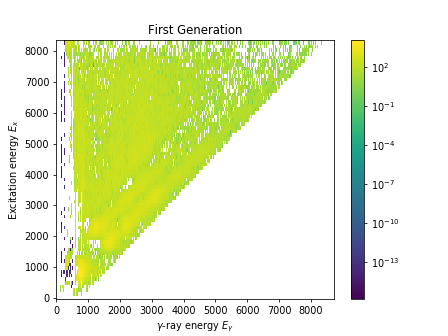

In [12]:
unfolded = unfolder(raw_positive)
firstgen = om.FirstGeneration()
primary = firstgen(unfolded)
primary.plot();

again, check the linearity using `unfolded` as `R1` and some arb. spectrum `R2`

<IPython.core.display.Javascript object>


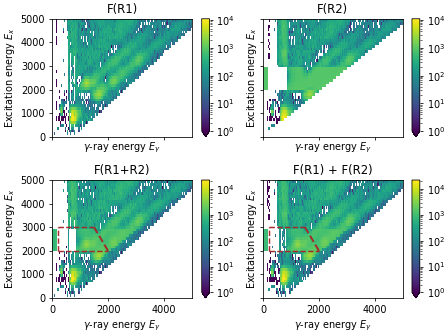

In [13]:
fig, axes = plt.subplots(2, 2, constrained_layout=True, sharex=True, sharey=True)
ax = axes.flatten()

r2 = unfolded.copy()
iE1 = r2.index_Ex(2000)
iE2 = r2.index_Ex(3000)
r2[iE1:iE2, :] = 1e3
r2[iE1:iE2, 10:40] *= 0
r2.cut_diagonal(E1=[0,0], E2=[1000,1000])

r1 = unfolded.copy()
primaries_1 = firstgen(r1)
primaries_1.plot(ax=ax[0], vmin=1);
ax[0].set_title("F(R1)")

primaries_2 = firstgen(r2)
primaries_2.plot(ax=ax[1], vmin=1);
ax[1].set_title("F(R2)")

primaries_both = firstgen(r1 + r2)
primaries_both.plot(ax=ax[2], vmin=1);
ax[2].set_title("F(R1+R2)")

sum_primaries = primaries_1 + primaries_2
sum_primaries.plot(ax=ax[3], vmin=1);
ax[3].set_title("F(R1) + F(R2)");

ax[0].set_xlim(0,5000)
ax[0].set_ylim(0,5000)


# highlight an area with differences
Ex_min = 2000
Ex_max = 3000
Eg_min = 200
Eg_max = 1500
ax[2].hlines(Ex_min, Eg_min, Ex_min, "brown", "--")
ax[2].hlines(Ex_max, Eg_min, Eg_max, "brown", "--")
ax[2].vlines(Eg_min, Ex_min, Ex_max, "brown", "--")
ax[2].plot([Ex_min, Eg_max], [Ex_min, Ex_max], "--", linewidth=2, color="brown")

ax[3].hlines(Ex_min, Eg_min, Ex_min, "brown", "--")
ax[3].hlines(Ex_max, Eg_min, Eg_max, "brown", "--")
ax[3].vlines(Eg_min, Ex_min, Ex_max, "brown", "--")
ax[3].plot([Ex_min, Eg_max], [Ex_min, Ex_max], "--", linewidth=2, color="brown")

fig.savefig("1gen.jpeg")

Again, we see that the lower two panels are not equal! (An area with difference is highlighted), so the operations are not linear